### 1. Time Series Classification Part 1: Feature Creation/Extraction
### An interesting task in machine learning is classification of time series. In this problem, we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.

###  Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/
### Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29 . 
### The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity.1 Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, avg rss23, and var rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.


### Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [1]:
import csv
import os, re
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

In [2]:
root_dir = "../Data/AReM/"
#Create data from the filename
def dataset_allocate(filename,start,end):
    
    data = []
    
    for i in range(start,end,1):
        path = root_dir+filename+"/dataset"+str(i)+".csv"
        sniffer = csv.Sniffer()
        separator = sniffer.sniff(open(path).read()).delimiter
        if separator == ",":
            df = pd.read_csv(path, skiprows=5, header=None, error_bad_lines=False, warn_bad_lines=False,index_col=None)
        else:
            df = pd.read_csv(path, skiprows=5, header=None, sep="\s+", error_bad_lines=False, warn_bad_lines=False,index_col=None)
        df.columns = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
        df['Foldername'] = filename
        df['Filename'] = "dataset"+str(i)
        data.append(df)

    final_df = pd.concat(data, axis=0, ignore_index=True)
    
    return final_df   

In [3]:
test_1_df = dataset_allocate('bending1',1,3)
train_1_df = dataset_allocate('bending1',3,8)

test_2_df = dataset_allocate('bending2',1,3)
train_2_df = dataset_allocate('bending2',3,7)

test_3_df = dataset_allocate('cycling',1,4)
train_3_df = dataset_allocate('cycling',4,16)

test_4_df = dataset_allocate('lying',1,4)
train_4_df = dataset_allocate('lying',4,16)

test_5_df = dataset_allocate('sitting',1,4)
train_5_df = dataset_allocate('sitting',4,16)

test_6_df = dataset_allocate('standing',1,4)
train_6_df = dataset_allocate('standing',4,16)

test_7_df = dataset_allocate('walking',1,4)
train_7_df = dataset_allocate('walking',4,16)

test_df = pd.concat([test_1_df,test_2_df,test_3_df,test_4_df,test_5_df,test_6_df,test_7_df])
train_df = pd.concat([train_1_df,train_2_df,train_3_df,train_4_df,train_5_df,train_6_df,train_7_df])

In [4]:
test_df

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Foldername,Filename
0,0,39.25,0.43,22.75,0.43,33.75,1.30,bending1,dataset1
1,250,39.25,0.43,23.00,0.00,33.00,0.00,bending1,dataset1
2,500,39.25,0.43,23.25,0.43,33.00,0.00,bending1,dataset1
3,750,39.50,0.50,23.00,0.71,33.00,0.00,bending1,dataset1
4,1000,39.50,0.50,24.00,0.00,33.00,0.00,bending1,dataset1
...,...,...,...,...,...,...,...,...,...
1435,118750,36.00,2.45,17.00,5.10,20.50,0.87,walking,dataset3
1436,119000,34.33,1.89,15.00,2.45,17.00,2.12,walking,dataset3
1437,119250,33.00,7.35,14.60,3.14,13.00,5.70,walking,dataset3
1438,119500,31.67,1.25,11.00,6.16,19.25,2.17,walking,dataset3


In [5]:
train_df

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Foldername,Filename
0,0,42.00,0.71,21.25,0.43,30.00,0.00,bending1,dataset3
1,250,41.50,0.50,20.25,1.48,31.25,1.09,bending1,dataset3
2,500,41.50,0.50,14.25,1.92,33.00,0.00,bending1,dataset3
3,750,40.75,0.83,15.75,0.43,33.00,0.00,bending1,dataset3
4,1000,40.00,0.71,20.00,2.74,32.75,0.43,bending1,dataset3
...,...,...,...,...,...,...,...,...,...
5755,118750,34.50,6.18,9.00,3.56,12.67,4.19,walking,dataset15
5756,119000,25.75,6.02,13.75,2.05,16.00,1.58,walking,dataset15
5757,119250,31.50,3.35,10.25,5.12,16.25,2.95,walking,dataset15
5758,119500,33.75,2.77,14.00,3.24,13.75,0.43,walking,dataset15


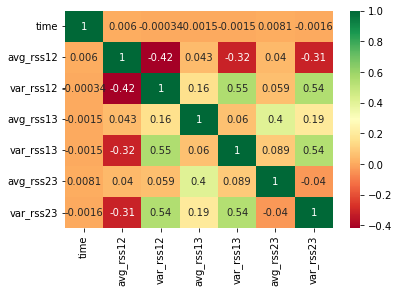

In [6]:
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn') #to check the correlation of the features
plt.show()

### Feature Extraction

Different types of time domain features used in time series classification are:

Means in each of the d dimensions

Standard deviations of the d dimensions

Skewness, Kurtosis and Higher order moments of the d dimensions

Maximum and Minimum values, Median, First Quartile and Third quartile of each of the d dimensions

Root Mean Square in each of the d dimensions

Variance of the d dimensions

Mean Absolute Deviation

Waveform Length

Zero Crossing 

### Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. We can normalize/standardize features or use them directly

In [7]:
cd = os.path.dirname(os.path.abspath(root_dir))
columns = range(1,100)
feat_list = []

for root, dirs, files in os.walk(cd):
    n = len(files)
    for x in range(1,n+1):
        rootname=root.split()[-1].split('\\')[-1]
        fname = "dataset"+str(x)+".csv"
        path = os.path.join(root, fname)
        sniffer = csv.Sniffer()
        sept = sniffer.sniff(open(path).read()).delimiter
        if sept == ",":
            df = pd.read_csv(path, skiprows=5, header=None, error_bad_lines=False, warn_bad_lines=False,index_col=None)
        else:
            df = pd.read_csv(path, skiprows=5, header=None, sep="\s+", error_bad_lines=False, warn_bad_lines=False,index_col=None)
        df.columns = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
        feat = []
        for i in df.columns:
            if i == 'time':
                continue
            feat.append(df[i].min())
            feat.append(df[i].max())
            feat.append(df[i].mean())
            feat.append(df[i].median())
            feat.append(df[i].std())
            feat.append(np.percentile(df[i],25))
            feat.append(np.percentile(df[i],75))
        feat = pd.DataFrame(feat).T
        feat['Foldername']=rootname
        feat['Filename']=fname
        feat_list.append(feat)

feat_list = pd.concat(feat_list,ignore_index=True)
feat_list

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,Foldername,Filename
0,37.25,45.00,40.624792,40.50,1.476967,39.25,42.0000,0.0,1.30,0.358604,...,36.00,0.00,1.92,0.570583,0.43,0.582915,0.0000,1.3000,bending1,dataset1.csv
1,38.00,45.67,42.812812,42.50,1.435550,42.00,43.6700,0.0,1.22,0.372438,...,34.50,0.00,3.11,0.571083,0.43,0.601010,0.0000,1.3000,bending1,dataset2.csv
2,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400,bending1,dataset3.csv
3,33.00,47.75,42.179813,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000,bending1,dataset4.csv
4,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000,bending1,dataset5.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,4.576562,...,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225,walking,dataset11.csv
84,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,4.456333,...,17.75,0.00,9.67,3.432562,3.20,1.732727,2.1575,4.5650,walking,dataset12.csv
85,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,4.371958,...,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350,walking,dataset13.csv
86,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,4.380583,...,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000,walking,dataset14.csv


In [8]:
columns = []
col_names = ['Min','Max','Mean','Median','Std','Q1','Q3']
for i in range(1,7):
    for j in col_names:
        columns.append(j+"_"+str(i))
columns.append('Foldername')
columns.append('Filename')
feat_list.columns = columns

In [9]:
td_feat_list = feat_list.drop(feat_list.columns[[-1,-2]], axis = 1)
td_feat_list

,Min_1,Max_1,Mean_1,Median_1,Std_1,Q1_1,Q3_1,Min_2,Max_2,Mean_2,...,Std_5,Q1_5,Q3_5,Min_6,Max_6,Mean_6,Median_6,Std_6,Q1_6,Q3_6
0,37.25,45.00,40.624792,40.50,1.476967,39.25,42.0000,0.0,1.30,0.358604,...,2.188449,33.0000,36.00,0.00,1.92,0.570583,0.43,0.582915,0.0000,1.3000
1,38.00,45.67,42.812812,42.50,1.435550,42.00,43.6700,0.0,1.22,0.372438,...,1.995255,32.0000,34.50,0.00,3.11,0.571083,0.43,0.601010,0.0000,1.3000
2,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,1.999604,35.3625,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400
3,33.00,47.75,42.179813,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,3.849448,30.4575,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000
4,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,2.411026,28.4575,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,4.576562,...,3.283983,13.7300,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225
84,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,4.456333,...,3.119856,13.5000,17.75,0.00,9.67,3.432562,3.20,1.732727,2.1575,4.5650
85,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,4.371958,...,2.823124,14.0000,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350
86,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,4.380583,...,3.131076,13.7500,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000


###  Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature

In [10]:
td_feat_list.std()

Min_1       9.569975
Max_1       4.394362
Mean_1      5.335700
Median_1    5.440054
Std_1       1.772185
Q1_1        6.153874
Q3_1        5.138925
Min_2       0.000000
Max_2       5.062729
Mean_2      1.574198
Median_2    1.412293
Std_2       0.884137
Q1_2        0.946386
Q3_2        2.125399
Min_3       2.956462
Max_3       4.875137
Mean_3      4.008228
Median_3    4.036396
Std_3       0.946670
Q1_3        4.220658
Q3_3        4.171628
Min_4       0.000000
Max_4       2.183625
Mean_4      1.166178
Median_4    1.145985
Std_4       0.458283
Q1_4        0.843405
Q3_4        1.552504
Min_5       6.124001
Max_5       5.741238
Mean_5      5.675543
Median_5    5.813782
Std_5       1.024918
Q1_5        6.096465
Q3_5        5.531720
Min_6       0.045838
Max_6       2.518921
Mean_6      1.154889
Median_6    1.086474
Std_6       0.517651
Q1_6        0.758687
Q3_6        1.523739
dtype: float64

In [11]:
def bootstrap(data, formula, loop, low, upper):  
    bootestimate = pd.DataFrame(columns = list(data.columns))
    for i in range(loop):
        boot = resample(data, replace=True, n_samples=data.shape[0])
        bootestimate = bootestimate.append(boot.apply(formula, ddof=1, axis = 0), ignore_index=True) #series to dataframe
    interval = bootestimate.apply(np.percentile, args=([low,upper],), axis = 0)
    ci = pd.Series([(round(interval.loc[0,col], 2), round(interval.loc[1,col],2)) for col in list(data.columns)], index=list(data.columns))    
    return ci

In [12]:
bootstrap(td_feat_list, np.std, 1000, 5, 95)

Min_1       (8.29, 10.75)
Max_1          (3.3, 5.3)
Mean_1       (4.67, 5.86)
Median_1     (4.77, 5.99)
Std_1        (1.57, 1.94)
Q1_1         (5.53, 6.62)
Q3_1         (4.29, 5.81)
Min_2          (0.0, 0.0)
Max_2         (4.63, 5.4)
Mean_2         (1.4, 1.7)
Median_2     (1.23, 1.54)
Std_2         (0.8, 0.94)
Q1_2         (0.83, 1.04)
Q3_2         (1.89, 2.29)
Min_3         (2.75, 3.1)
Max_3         (4.2, 5.41)
Mean_3       (3.42, 4.48)
Median_3     (3.43, 4.52)
Std_3        (0.76, 1.11)
Q1_3         (3.64, 4.71)
Q3_3         (3.55, 4.67)
Min_4          (0.0, 0.0)
Max_4        (1.98, 2.35)
Mean_4       (1.08, 1.22)
Median_4      (1.05, 1.2)
Std_4        (0.42, 0.49)
Q1_4         (0.78, 0.89)
Q3_4         (1.43, 1.62)
Min_5        (4.41, 7.57)
Max_5        (4.77, 6.57)
Mean_5       (4.41, 6.82)
Median_5     (4.55, 6.99)
Std_5         (0.8, 1.23)
Q1_5         (4.77, 7.33)
Q3_5         (4.33, 6.62)
Min_6         (0.0, 0.08)
Max_6        (2.25, 2.76)
Mean_6       (1.06, 1.22)
Median_6    

### The three most important time-domain features selected are - Mean, Max and Third Quartile

### Time Series Classification : Binary and Multiclass Classification

###  Binary Classification Using Logistic Regression

### Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

In [11]:
#giving labels 
imp_feat =  feat_list
imp_feat.loc[imp_feat['Foldername'].isin(['bending1','bending2']),'Label'] = 0
imp_feat.loc[~imp_feat['Foldername'].isin(['bending1','bending2']),'Label'] = 1
imp_feat

,Min_1,Max_1,Mean_1,Median_1,Std_1,Q1_1,Q3_1,Min_2,Max_2,Mean_2,...,Min_6,Max_6,Mean_6,Median_6,Std_6,Q1_6,Q3_6,Foldername,Filename,Label
0,37.25,45.00,40.624792,40.50,1.476967,39.25,42.0000,0.0,1.30,0.358604,...,0.00,1.92,0.570583,0.43,0.582915,0.0000,1.3000,bending1,dataset1.csv,0.0
1,38.00,45.67,42.812812,42.50,1.435550,42.00,43.6700,0.0,1.22,0.372438,...,0.00,3.11,0.571083,0.43,0.601010,0.0000,1.3000,bending1,dataset2.csv,0.0
2,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400,bending1,dataset3.csv,0.0
3,33.00,47.75,42.179813,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000,bending1,dataset4.csv,0.0
4,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000,bending1,dataset5.csv,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,4.576562,...,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225,walking,dataset11.csv,1.0
84,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,4.456333,...,0.00,9.67,3.432562,3.20,1.732727,2.1575,4.5650,walking,dataset12.csv,1.0
85,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,4.371958,...,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350,walking,dataset13.csv,1.0
86,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,4.380583,...,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000,walking,dataset14.csv,1.0


In [12]:
#train data

In [14]:
file_opt = ['dataset1.csv','dataset2.csv']
folder_opt = ['walking','sitting','cycling','lying','standing']
feat_list_train = feat_list.loc[~feat_list['Filename'].isin(file_opt)]
feat_list_train = feat_list_train.loc[~(feat_list['Foldername'].isin(folder_opt) &
                                               feat_list['Filename'].isin(['dataset3.csv']))]   
feat_list_train.loc[feat_list_train['Foldername'].isin(folder_opt),'Label'] = '0'
feat_list_train.loc[~feat_list_train['Foldername'].isin(folder_opt),'Label'] = '1'
feat_list_train = feat_list_train.drop(['Foldername','Filename'],axis=1)

In [15]:
feat_list_train

,Min_1,Max_1,Mean_1,Median_1,Std_1,Q1_1,Q3_1,Min_2,Max_2,Mean_2,...,Q1_5,Q3_5,Min_6,Max_6,Mean_6,Median_6,Std_6,Q1_6,Q3_6,Label
2,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400,1
3,33.00,47.75,42.179813,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000,1
4,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000,1
5,37.00,48.00,43.454958,43.25,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.00,0.00,5.26,0.679646,0.50,0.622534,0.4300,0.8700,1
6,36.25,48.00,43.969125,44.50,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.75,0.00,2.96,0.555313,0.49,0.487826,0.0000,0.8300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,4.576562,...,13.7300,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225,0
84,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,4.456333,...,13.5000,17.75,0.00,9.67,3.432562,3.20,1.732727,2.1575,4.5650,0
85,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,4.371958,...,14.0000,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350,0
86,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,4.380583,...,13.7500,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000,0


Text(0.5, 1.008, 'Scatterplot of the features selected')

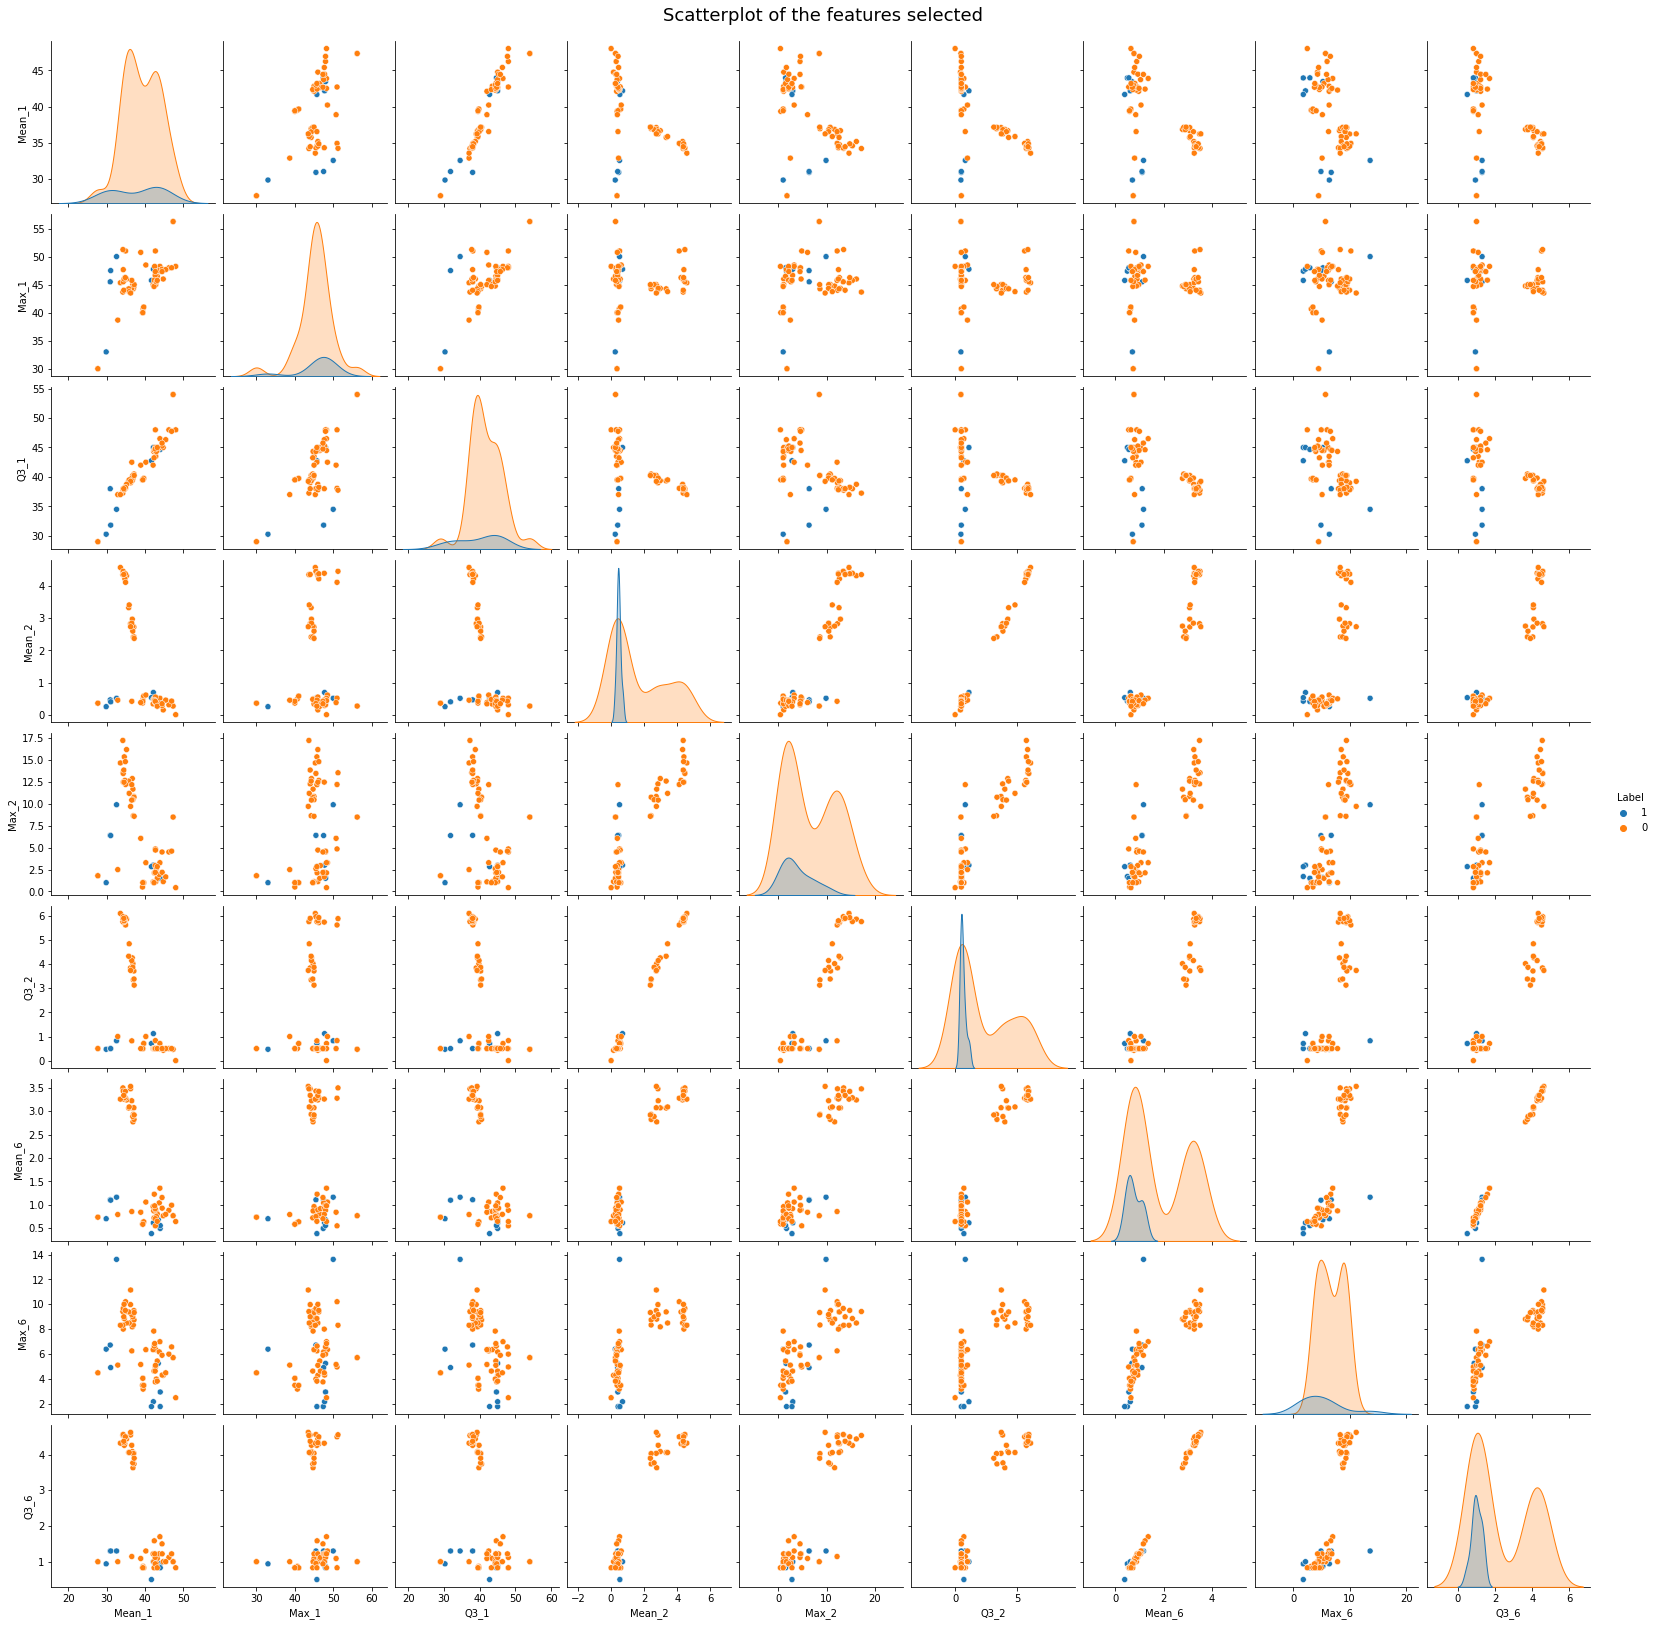

In [16]:
plot = sns.pairplot(feat_list_train[['Mean_1','Max_1','Q3_1','Mean_2','Max_2','Q3_2','Mean_6','Max_6','Q3_6','Label']],hue='Label')
plot.fig.suptitle("Scatterplot of the features selected", y=1.008, fontsize = 18)

###  Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results 

In [18]:
def splitdata(foldername, start, end, l, is_test, multiclass):
    if is_test == 1:
        tmp = test_df.loc[test_df['Foldername'] == foldername]
    else:
        tmp = train_df.loc[train_df['Foldername'] == foldername]
    dlist = []
    for i in range(start,end):
        datasetname = "dataset"+str(i)
        df = tmp.loc[tmp['Filename']==datasetname]
        df = df.drop(['time','Filename','Foldername'],axis=1)
     
        split = int(len(df)/l)
        data=[]
        for j in range(l):
            splitdf = df[(split*j):(j+1)*split]
            splitdf.reset_index(drop=True, inplace=True)
            data.append(splitdf)
        split_df=pd.concat(data,axis=1,ignore_index=True)
        tmp_features = []
        for i in split_df.columns:
            if i == 'time':
                continue
            tmp_features.append(split_df[i].mean())
            tmp_features.append(split_df[i].max())
            tmp_features.append(np.percentile(split_df[i],75))
        tmp_features = pd.DataFrame(tmp_features).T
        dlist.append(tmp_features)
    df_td_feat_splitted = pd.concat(dlist,ignore_index=True)
    columns = []
    column_names = ['Mean','Max','Q3']
    for i in range(1,(l)*6+1):
        for j in column_names:
            columns.append(j+"_"+str(i))
    df_td_feat_splitted.columns = columns
    if multiclass:
        df_td_feat_splitted['Label'] = 'bending' if foldername == "bending1" or foldername == "bending2" else foldername
    else:
        df_td_feat_splitted['Label'] = 1 if foldername == "bending1" or foldername == "bending2" else 0
    return df_td_feat_splitted

#Calling function for train split dataset
def splitontrain(l,multiclass):
    train_split1 = splitdata('bending1',3,8,l,0,multiclass)
    train_split2 = splitdata('bending2',3,7,l,0,multiclass)
    train_split3 = splitdata('cycling',4,16,l,0,multiclass)
    train_split4 = splitdata('lying',4,16,l,0,multiclass)
    train_split5 = splitdata('sitting',4,16,l,0,multiclass)
    train_split6 = splitdata('standing',4,16,l,0,multiclass)
    train_split7 = splitdata('walking',4,16,l,0,multiclass)
    train_data_split = pd.concat([train_split1,train_split2,train_split3,train_split4,train_split5,train_split6,train_split7],ignore_index=True)
    return train_data_split

#Calling function for test split dataset
def splitontest(l,multiclass):
    test_split1 = splitdata('bending1',1,3,l,1,multiclass)
    test_split2 = splitdata('bending2',1,3,l,1,multiclass)
    test_split3 = splitdata('cycling',1,4,l,1,multiclass)
    test_split4 = splitdata('lying',1,4,l,1,multiclass)
    test_split5 = splitdata('sitting',1,4,l,1,multiclass)
    test_split6 = splitdata('standing',1,4,l,1,multiclass)
    test_split7 = splitdata('walking',1,4,l,1,multiclass)
    test_data_split = pd.concat([test_split1,test_split2,test_split3,test_split4,test_split5,test_split6,test_split7],ignore_index=True)
    return test_data_split


In [19]:
train_split_2 = splitontrain(2,0)
train_split_2 

,Mean_1,Max_1,Q3_1,Mean_2,Max_2,Q3_2,Mean_3,Max_3,Q3_3,Mean_4,...,Mean_10,Max_10,Q3_10,Mean_11,Max_11,Q3_11,Mean_12,Max_12,Q3_12,Label
0,44.057167,46.50,45.0000,0.381042,1.50,0.5000,23.096792,29.25,24.0000,0.493458,...,0.501167,4.44,0.7100,34.883375,38.25,36.2500,0.388333,1.50,0.7100,1
1,43.278875,47.75,45.2500,0.673292,3.00,1.0000,23.141250,30.00,24.8125,0.808042,...,1.171792,5.15,1.4800,30.965708,38.50,33.7500,0.586083,2.18,0.8700,1
2,41.621208,45.75,44.2500,0.623083,2.83,0.8300,19.081458,28.25,24.0000,1.115083,...,0.568667,2.35,0.8300,29.635833,36.00,30.5625,0.347500,1.50,0.5000,1
3,44.117042,48.00,45.0000,0.250042,1.30,0.5000,17.744167,27.00,20.0000,1.123000,...,0.575708,5.21,0.8225,22.850875,26.00,23.7500,0.543875,4.06,0.7100,1
4,43.486208,45.00,44.5000,0.378667,1.30,0.5000,16.397250,26.33,18.0000,0.662958,...,0.669750,3.56,0.8875,21.882042,26.00,23.5000,0.585750,2.96,0.8300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,33.334500,45.00,36.8125,4.408083,11.78,5.8700,15.445333,22.75,17.3125,3.271417,...,3.183042,9.00,4.3200,15.755958,23.33,18.0625,3.290292,8.32,4.4525,0
65,34.036750,44.50,37.7500,4.778292,13.47,6.5050,15.177083,22.00,17.0000,3.394083,...,3.160375,7.46,4.0600,15.520375,23.25,17.7500,3.321417,9.67,4.3950,0
66,34.033875,43.33,37.5000,4.574625,12.47,6.0300,15.340417,22.67,17.2500,3.025417,...,3.031958,8.22,3.9775,15.218417,21.33,17.2500,3.432208,8.64,4.5125,0
67,34.920792,44.00,37.8125,4.177958,14.82,5.4550,15.515875,24.25,17.0625,3.235125,...,3.176250,9.90,4.1500,15.939417,23.50,18.0625,3.418667,9.51,4.4525,0


Text(0.5, 1.008, 'Scatterplot of the features selected for the training set split into 2')

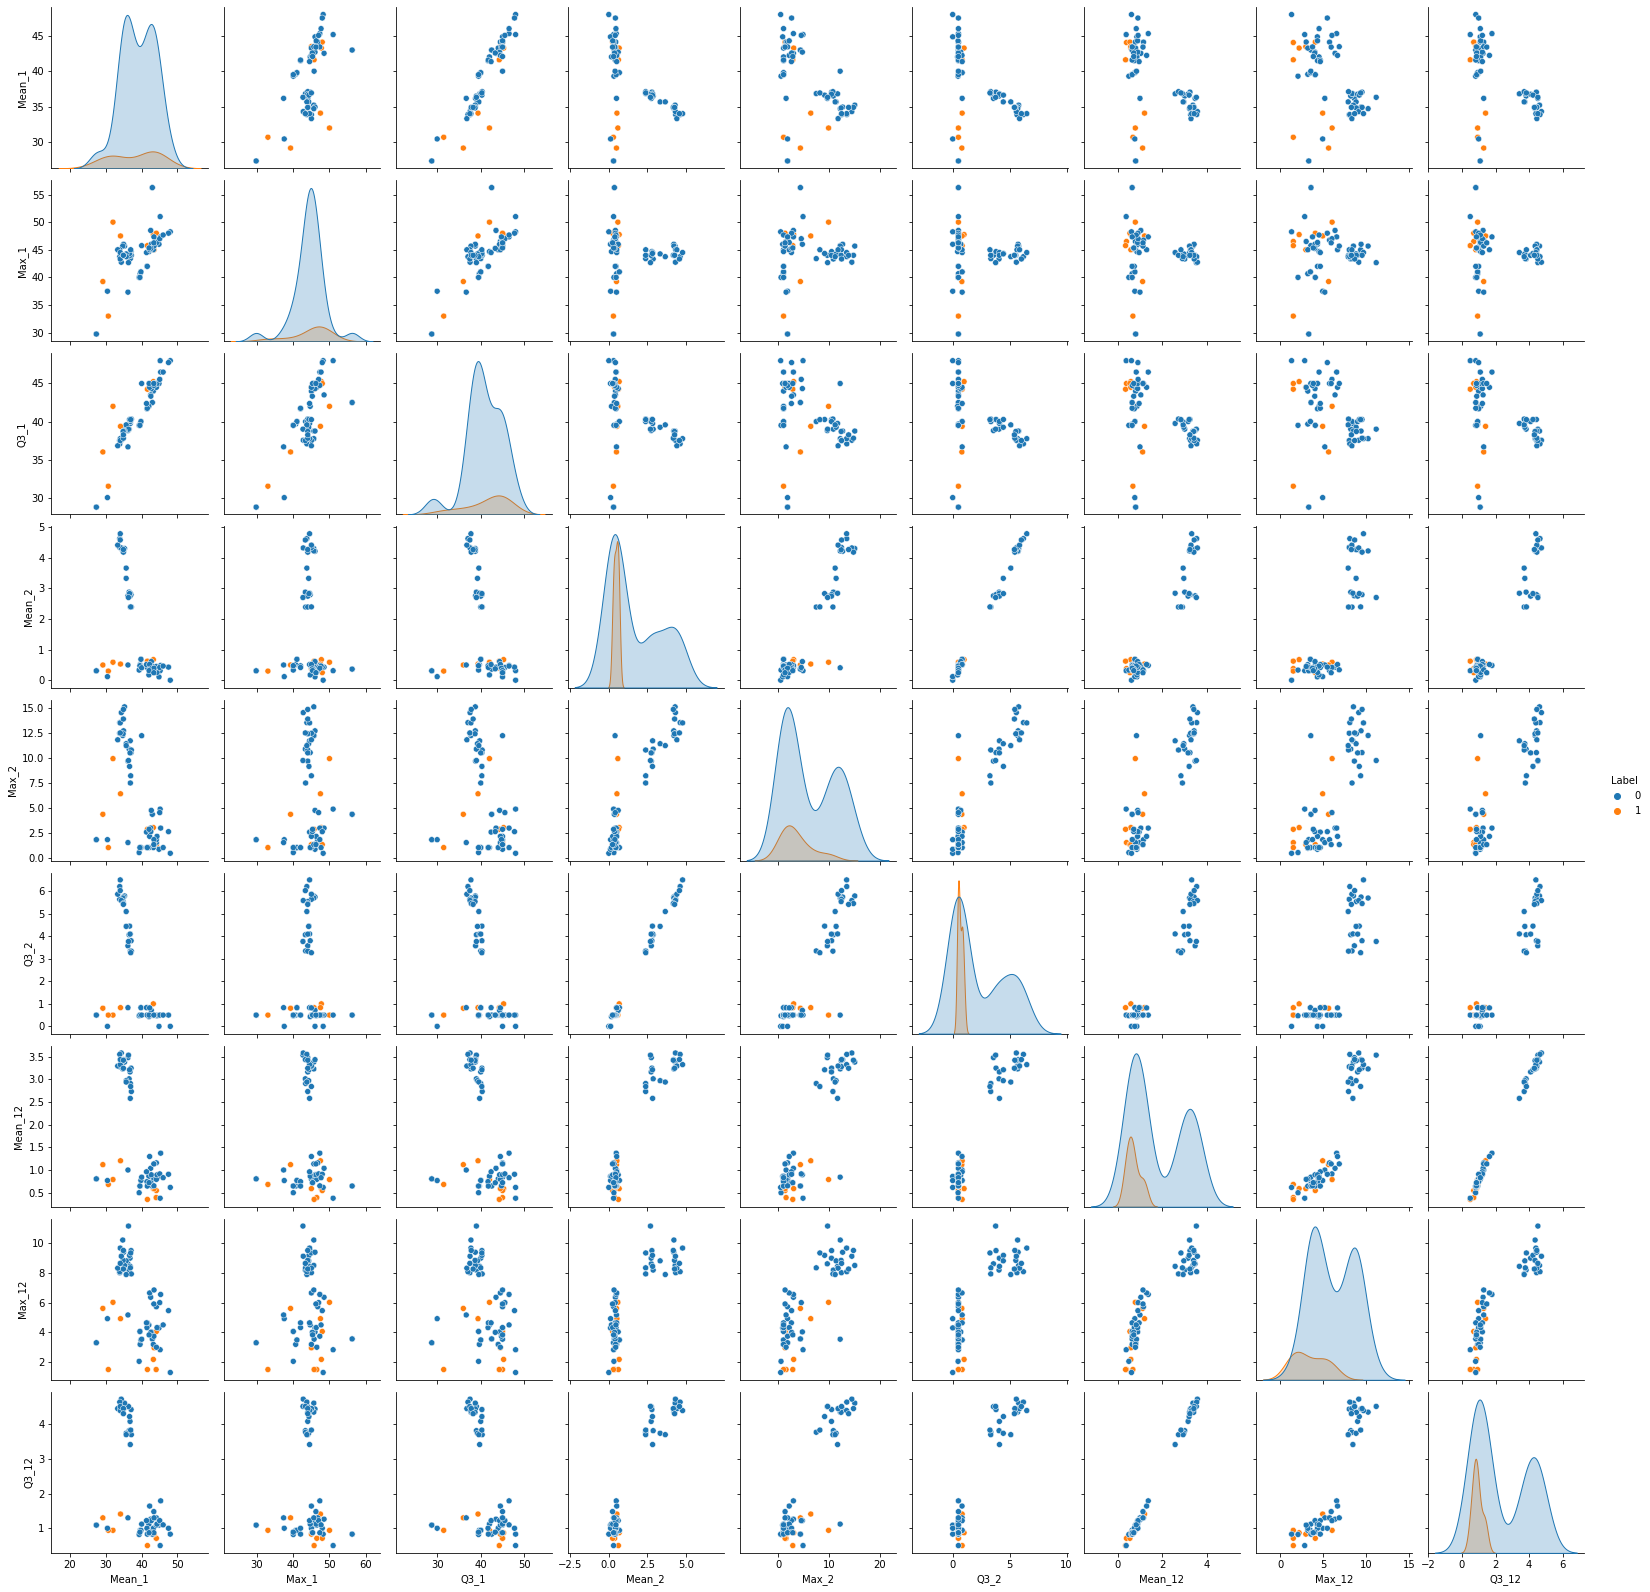

In [20]:
plot_2 = sns.pairplot(train_split_2[['Mean_1','Max_1','Q3_1','Mean_2','Max_2','Q3_2','Mean_12','Max_12','Q3_12','Label']],hue='Label')
plot.fig.suptitle("Scatterplot of the features selected for the training set split into 2", y=1.008, fontsize = 18)

we break time series into 2 equal time length, the scatterplots of time-domain features of series 1, 2 and 6 become more sparse than orignial, because the whole period in 1 length-time data breaks into 2 periods in 2 length-time data. Series 1, 2 and 6 in 2-length data now only capture the first period of the whole series in the original. However, the overall pattern in 2 equal time-length plot remains, like the one in whole time-length plot, which means even though we break the times series into 2 length, first time length still has similar pattern like the overall but more sparse. From the distribution of each time-domain features in 2 time-length scatterplot, there are slightly difference, but overall it looks similar with the whole time length.

###  Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation.

In [21]:
out = {'l':[],'no_of_features(p)':[],'f1_score':[], 'feat_selected': []}
feat_support = {'l':[],"val":[]}
for i in range(1,21):
    out['l'].append(i)
    feat_support['l'].append(i)
    train_split_l = splitontrain(i,0)
    X = train_split_l.drop(train_split_l.columns[-1],axis=1)
    y = train_split_l[train_split_l.columns[-1]]
    model = LogisticRegression(max_iter=1000)
    selector = RFECV(estimator=model,step=1, cv=StratifiedKFold(5), scoring='accuracy')
    selector = selector.fit(X, y)
    out['no_of_features(p)'].append(selector.n_features_)
    out['f1_score'].append(f1_score(y, selector.predict(X)))
    out['feat_selected'].append(X.columns[selector.support_])
    feat_support['val'].append(selector.support_)
out_df = pd.DataFrame(out)
feat_support_df = pd.DataFrame(feat_support)
print(out_df)

     l  no_of_features(p)  f1_score  \
0    1                 14  1.000000   
1    2                  4  1.000000   
2    3                  1  0.875000   
3    4                  5  1.000000   
4    5                  5  1.000000   
5    6                  4  1.000000   
6    7                  9  1.000000   
7    8                 24  1.000000   
8    9                  8  1.000000   
9   10                  1  0.875000   
10  11                  1  0.941176   
11  12                 24  1.000000   
12  13                  1  0.875000   
13  14                  1  0.875000   
14  15                 21  1.000000   
15  16                 25  1.000000   
16  17                  1  0.941176   
17  18                  1  0.941176   
18  19                  9  1.000000   
19  20                 40  1.000000   

                                        feat_selected  
0   Index(['Mean_1', 'Max_1', 'Q3_1', 'Max_2', 'Q3...  
1   Index(['Mean_3', 'Mean_5', 'Max_5', 'Q3_5'], d...  
2           

In [22]:
best_l = out['l'][out['f1_score'].index(np.amax(out['f1_score']))]
best_feat = feat_support['val'][feat_support['l'].index(best_l)]
columns = []
column_names = ['Mean','Max','Q3']
for i in range(1,(best_l)*6+1):
    for j in column_names:
        columns.append(j+"_"+str(i))
selected_feature=[]
for i,x in enumerate(best_feat):
    if x:
        selected_feature.append(columns[i])
print("The best l,p pair is: (",best_l,",",np.amax(out['f1_score']),")")
print("The best selected features are:",selected_feature)

The best l,p pair is: ( 1 , 1.0 )
The best selected features are: ['Mean_1', 'Max_1', 'Q3_1', 'Max_2', 'Q3_2', 'Mean_3', 'Q3_3', 'Q3_4', 'Mean_5', 'Max_5', 'Q3_5', 'Mean_6', 'Max_6', 'Q3_6']


Right way to perform the cross validation: First do the K fold and then do the feature selection. Based on these selected features, run the logistic regression model
  
Wrong way to perform the cross validation: First do the feature selection and then do the K fold. Finally, run the logistic  regression model. The problem of this way is that feature selection should include in cross validation, not outside the cv process. By doing the wrong way, the model we built in feature selection has already seen the validation data, which turns out to have a good performance in predicting validation data.

### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [23]:
split_data = splitontrain(best_l,0)
X_train = split_data.drop(split_data.columns[-1],axis=1)
y_train = split_data[split_data.columns[-1]]
X_train = X_train[selected_feature]

best_model = LogisticRegression(max_iter=100,random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_train)
statModel = sm.Logit(y_train, X_train).fit_regularized()
print("Parameters of logsitic regression")
print(statModel.params)
print("p-values")
print(statModel.pvalues)
print(statModel.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0804659276948983e-10
            Iterations: 37
            Function evaluations: 43
            Gradient evaluations: 37
Parameters of logsitic regression
Mean_1   -1.908733
Max_1     4.206720
Q3_1     -6.180820
Max_2    -2.214122
Q3_2     -2.605369
Mean_3    1.416148
Q3_3     -3.436739
Q3_4     -2.456014
Mean_5    7.646689
Max_5     3.041032
Q3_5     -0.606019
Mean_6   -1.911645
Max_6    -5.004407
Q3_6     -2.433345
dtype: float64
p-values
Mean_1    1.0
Max_1     1.0
Q3_1      1.0
Max_2     1.0
Q3_2      1.0
Mean_3    1.0
Q3_3      1.0
Q3_4      1.0
Mean_5    1.0
Max_5     1.0
Q3_5      1.0
Mean_6    1.0
Max_6     1.0
Q3_6      1.0
dtype: float64
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:                   69
Model:                          Logit   Df Residuals:                       55
Method:       

In [24]:
cnf_matrix= confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(cnf_matrix)

Confusion Matrix:
[[60  0]
 [ 0  9]]


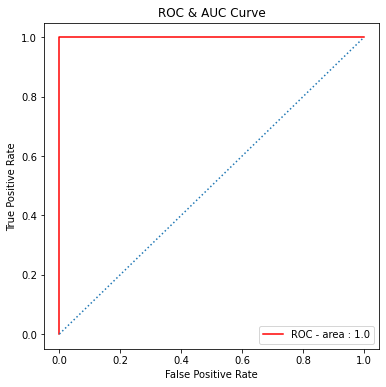

Accuracy score on Train data is  1.0


In [25]:
TN, FP, FN, TP = cnf_matrix.ravel()
FPR, TPR,threshold = roc_curve(y_train, y_pred)
area_under_the_curve = auc(FPR, TPR)
txt = 'ROC - area : ' + str(area_under_the_curve)
plt.figure(figsize=(6, 6))
plt.plot(FPR, TPR, color='red', label=txt)
plt.plot([0, 1], [0, 1], linestyle='dotted')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC & AUC Curve')
plt.legend()
plt.show()

train_accuracy = metrics.accuracy_score(y_train, y_pred)
print("Accuracy score on Train data is ",train_accuracy)

### Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [26]:
def plot_curve(y_test,y_pred):
    cnf_matrix= confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cnf_matrix.ravel()
    FPR, TPR,threshold = roc_curve(y_test, y_pred)
    area_under_the_curve = auc(FPR, TPR)
    txt = 'ROC - area : ' + str(area_under_the_curve)
    plt.figure(figsize=(6, 6))
    plt.plot(FPR, TPR, color='red', label=txt)
    plt.plot([0, 1], [0, 1], linestyle='dotted')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC & AUC Curve')
    plt.legend()
    plt.show()

Confusion Matrix
[[15  0]
 [ 0  4]]


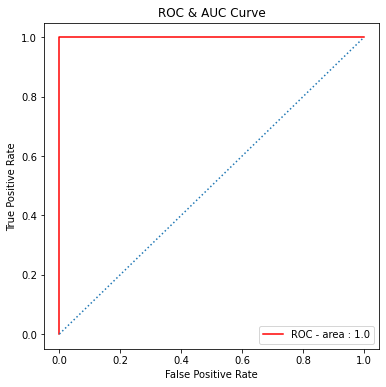

Accuracy score on the Test data is  1.0


In [27]:
X_train = split_data.drop(split_data.columns[-1],axis=1)
y_train = split_data[split_data.columns[-1]]
best_train_model = LogisticRegression()
best_train_model.fit(X_train, y_train)

test_set = splitontest(best_l,0)
X_test = test_set.drop(test_set.columns[-1],axis=1)
y_test = test_set[test_set.columns[-1]]

y_pred_test = best_train_model.predict(X_test)
cnf_matrix= confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix")
print(cnf_matrix)
plot_curve(y_test, y_pred_test)
test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
print("Accuracy score on the Test data is ",test_accuracy)

The accuracy on both Test and Train data 1.0

###  Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes the classes are well separated. As per the output given above in (iv), there is complete separation. Yes the parameteres are highly unstable

###  From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

Yes. There are imbalanced classes. From the confusion matrix obtained, it is observed that the we can see that the number of non-bending class (60 with label 0) has more samples than bending class (only 9 with label 1).

In [28]:
from imblearn.under_sampling import RandomUnderSampler

In [29]:
out_7 = {'l':[],'no_of_features':[],'f1_score':[], 'feat_selected': []}
feat_support_7 = {'l':[],"val":[]}
for i in range(1,21):
    out_7['l'].append(i)
    feat_support_7['l'].append(i)
    trainsplit_l = splitontrain(i,0)
    X_7 = trainsplit_l.drop(trainsplit_l.columns[-1],axis=1)
    y_7 = trainsplit_l[trainsplit_l.columns[-1]]
    random_samp = RandomUnderSampler(random_state=5)
    X_random_samp, y_random_samp = random_samp.fit_resample(X_7, y_7)
    model_control_sample = LogisticRegression(max_iter=100)
    selector_7 = RFECV(estimator=model_control_sample, cv=StratifiedKFold(5), scoring='accuracy')
    selector_7.fit(X_random_samp, y_random_samp)
    out_7['no_of_features'].append(selector_7.n_features_)
    out_7['f1_score'].append(f1_score(y_random_samp, selector_7.predict(X_random_samp)))
    out_7['feat_selected'].append(X_random_samp.columns[selector_7.support_])
    feat_support_7['val'].append(selector_7.support_)
out7_df = pd.DataFrame(out_7)
print(out7_df)

     l  no_of_features  f1_score  \
0    1               3  1.000000   
1    2               1  0.941176   
2    3               7  1.000000   
3    4               8  1.000000   
4    5              11  1.000000   
5    6               7  1.000000   
6    7               8  1.000000   
7    8               8  1.000000   
8    9              11  1.000000   
9   10              14  1.000000   
10  11             122  1.000000   
11  12               3  1.000000   
12  13              14  1.000000   
13  14               2  1.000000   
14  15               9  1.000000   
15  16               6  1.000000   
16  17               5  1.000000   
17  18               5  1.000000   
18  19               8  1.000000   
19  20               4  1.000000   

                                        feat_selected  
0   Index(['Mean_3', 'Mean_5', 'Max_5'], dtype='ob...  
1                    Index(['Max_5'], dtype='object')  
2   Index(['Mean_3', 'Q3_3', 'Mean_5', 'Max_5', 'Q...  
3   Index(['Mean_3'

In [30]:
best_control_sample_l = out_7['l'][out_7['f1_score'].index(np.amax(out_7['f1_score']))]
best_feat_control_sample = feat_support_7['val'][feat_support_7['l'].index(best_control_sample_l)]
columns_7 = []
column_names_7 = ['Mean','Max','Q3']
for i in range(1,(best_control_sample_l)*6+1):
    for j in column_names_7:
        columns_7.append(j+"_"+str(i))
control_sample_selected_feat=[]
for i,x in enumerate(best_feat_control_sample):
    if x:
        control_sample_selected_feat.append(columns_7[i])
print("The best l,p pair is: (",best_control_sample_l,",",np.amax(out_7['f1_score']),")")
print("The best selected features are:",control_sample_selected_feat)

The best l,p pair is: ( 1 , 1.0 )
The best selected features are: ['Mean_3', 'Mean_5', 'Max_5']


Confusion Matrix
[[9 0]
 [0 9]]


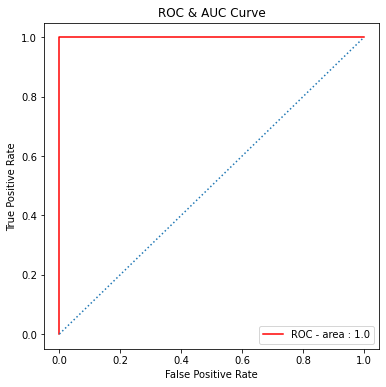

The accuracy score on Train data is  1.0


In [31]:
split_data_control_sample = splitontrain(best_control_sample_l,0)
X_train_control_sample = split_data_control_sample.drop(split_data_control_sample.columns[-1],axis=1)
y_train_control_sample = split_data_control_sample[split_data_control_sample.columns[-1]]

control_sample = RandomUnderSampler(random_state=5)
X_train_control_sample, y_train_control_sample = control_sample.fit_resample(X_train_control_sample, y_train_control_sample)

control_sample_model = LogisticRegression()
control_sample_model.fit(X_train_control_sample, y_train_control_sample)
y_pred_control_sample = control_sample_model.predict(X_train_control_sample)

cnf_matrix_7= confusion_matrix(y_train_control_sample, y_pred_control_sample)
print("Confusion Matrix")
print(cnf_matrix_7)
plot_curve(y_train_control_sample, y_pred_control_sample)
train_accuracy_control_sample = metrics.accuracy_score(y_train_control_sample, y_pred_control_sample)
print("The accuracy score on Train data is ",train_accuracy_control_sample)

Confusion Matrix
[[15  0]
 [ 0  4]]


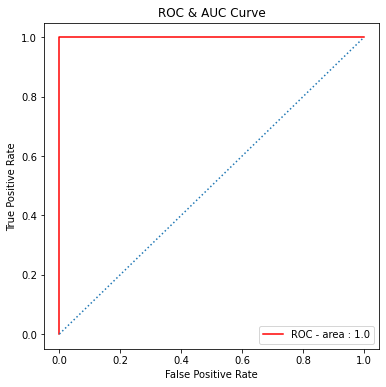

The accuracy score on Test data is  1.0


In [32]:
split_data_control_sample_test = splitontest(best_control_sample_l,0)
X_test_control_sample = split_data_control_sample_test.drop(split_data_control_sample_test.columns[-1],axis=1)
y_test_control_sample = split_data_control_sample_test[split_data_control_sample_test.columns[-1]]

y_pred_test_control_sample = control_sample_model.predict(X_test_control_sample)

cnf_matrix_test_7= confusion_matrix(y_test_control_sample, y_pred_test_control_sample)
print("Confusion Matrix")
print(cnf_matrix_test_7)
plot_curve(y_test_control_sample, y_pred_test_control_sample)
test_accuracy = metrics.accuracy_score(y_test_control_sample, y_pred_test_control_sample)
print("The accuracy score on Test data is ",test_accuracy)

### (b) Binary Classification Using L1-penalized logistic regression

### i. Repeat 2(a)iii using L1-penalized logistic regression, i.e. instead of using p values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [33]:
L1_log_regression = {'l':[],'best_C':[],'accuracy':[]}
cs_ = []
for i in range(1,21):
    L1_log_regression['l'].append(i)
    train_split_by_l = splitontrain(i,0)
    X_l1 = train_split_by_l.drop(train_split_by_l.columns[-1],axis=1)
    y_l1 = train_split_by_l[train_split_by_l.columns[-1]]
    X_l1_norm = preprocessing.scale(X_l1)
   
    model_l1 = LogisticRegressionCV(penalty='l1', cv = 5, solver='saga', multi_class = "ovr",scoring = 'accuracy',refit="True", random_state=5)
    model_l1.fit(X_l1_norm, y_l1)
    best_C = model_l1.C_[0]
    L1_log_regression['best_C'].append(best_C)
    score_l1 = model_l1.score(X_l1_norm, y_l1)
    L1_log_regression['accuracy'].append(score_l1)
    
L1_log_regr_df = pd.DataFrame(L1_log_regression)
L1_log_regr_df

,l,best_C,accuracy
0,1,0.359381,0.971014
1,2,0.359381,0.956522
2,3,2.782559,1.000000
3,4,0.359381,0.971014
4,5,2.782559,1.000000
5,6,0.359381,0.956522
6,7,2.782559,1.000000
7,8,0.359381,0.956522
8,9,2.782559,1.000000
9,10,0.359381,0.971014


In [34]:
best_l_log_regr_l1 = L1_log_regression['l'][L1_log_regression['accuracy'].index(np.amax(L1_log_regression['accuracy']))]
best_C_log_regr_l1 = L1_log_regression['best_C'][L1_log_regression['accuracy'].index(np.amax(L1_log_regression['accuracy']))]
print("The best l,C pair obtained is: (",best_l_log_regr_l1,",",best_C_log_regr_l1,")")

The best l,C pair obtained is: ( 3 , 2.782559402207126 )


Confusion Matrix
[[60  0]
 [ 0  9]]


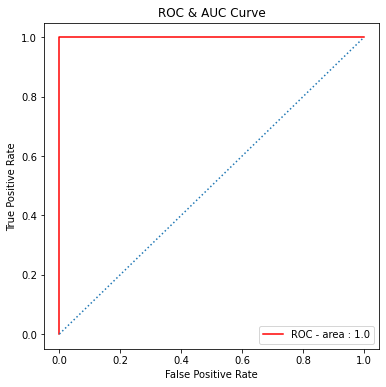

The accuracy score on Train data is  1.0


In [35]:
#using liblinear solver as recommended
split_data_log_regr = splitontrain(best_l_log_regr_l1,0)
X_train_log_regr = split_data_log_regr.drop(split_data_log_regr.columns[-1],axis=1)
y_train_log_regr = split_data_log_regr[split_data_log_regr.columns[-1]]

best_model_log_regr = LogisticRegression(penalty="l1", solver="liblinear",C=best_C_log_regr_l1,random_state=42)
best_model_log_regr.fit(X_train_log_regr, y_train_log_regr)
y_pred_log_regr = best_model_log_regr.predict(X_train_log_regr)

cnf_matrix_l1= confusion_matrix(y_train_log_regr, y_pred_log_regr)
print("Confusion Matrix")
print(cnf_matrix_l1)

plot_curve(y_train_log_regr, y_pred_log_regr)

train_accuracy_l1 = metrics.accuracy_score(y_train_log_regr, y_pred_log_regr)
print("The accuracy score on Train data is ",train_accuracy_l1)

Confusion Matrix
[[15  0]
 [ 0  4]]


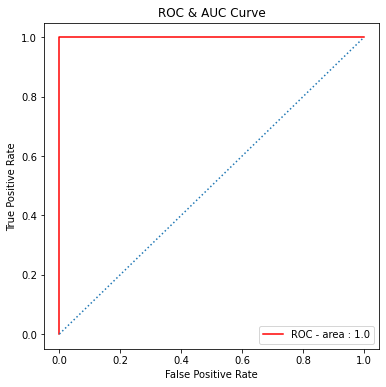

The accuracy score on Test data is  1.0


In [36]:
#using liblinear solver
split_data_log_regr_test = splitontest(best_l_log_regr_l1,0)
X_test_log_regr = split_data_log_regr_test.drop(split_data_log_regr_test.columns[-1],axis=1)
y_test_log_regr = split_data_log_regr_test[split_data_log_regr_test.columns[-1]]

y_pred_test_log_regr = best_model_log_regr.predict(X_test_log_regr)

cnf_matrix_test= confusion_matrix(y_test_log_regr, y_pred_test_log_regr)
print("Confusion Matrix")
print(cnf_matrix_test)

plot_curve(y_test_log_regr, y_pred_test_log_regr)

test_accuracy_l1 = metrics.accuracy_score(y_test_log_regr, y_pred_test_log_regr)
print("The accuracy score on Test data is ",test_accuracy_l1)

Confusion Matrix
[[60  0]
 [ 0  9]]


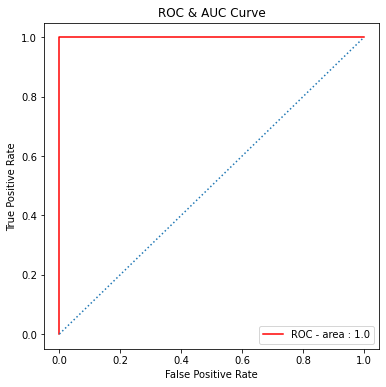

The accuracy score on Train data is  1.0


In [38]:
#using saga solver
split_data_log_regression = splitontrain(best_l_log_regr_l1,0)
X_train_log_regression = split_data_log_regression.drop(split_data_log_regression.columns[-1],axis=1)
y_train_log_regression = split_data_log_regression[split_data_log_regression.columns[-1]]

X_l1_norm_train = preprocessing.scale(X_train_log_regression)

best_model_l1_logreg = LogisticRegressionCV(penalty='l1', cv = 5, solver='saga', multi_class = "ovr", scoring = 'accuracy', refit="True", random_state=5)
best_model_l1_logreg.fit(X_l1_norm_train, y_train_log_regression)
y_pred_log_regr_l1 = best_model_l1_logreg.predict(X_l1_norm_train)


cnf_matrix_l1= confusion_matrix(y_train_log_regression, y_pred_log_regr_l1)
print("Confusion Matrix")
print(cnf_matrix_l1)

plot_curve(y_train_log_regression, y_pred_log_regr_l1)

train_accuracy_l1 = metrics.accuracy_score(y_train_log_regression, y_pred_log_regr_l1)
print("The accuracy score on Train data is ",train_accuracy_l1)

Confusion Matrix
[[ 2 13]
 [ 0  4]]


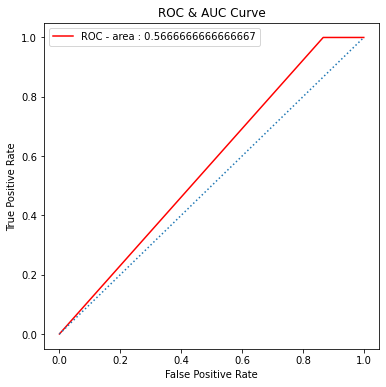

The accuracy score on Test data is  0.3157894736842105


In [40]:
#using saga solver
split_data_log_regr_test_l1 = splitontest(best_l_log_regr_l1,0)
X_test_log_regr_l1 = split_data_log_regr_test_l1.drop(split_data_log_regr_test_l1.columns[-1],axis=1)
y_test_log_regr_l1 = split_data_log_regr_test_l1[split_data_log_regr_test_l1.columns[-1]]

y_pred_test_log_regr_l1 = best_model_l1_logreg.predict(X_test_log_regr_l1)

cnf_matrix_l1_test= confusion_matrix(y_test_log_regr_l1, y_pred_test_log_regr_l1)
print("Confusion Matrix")
print(cnf_matrix_l1_test)

plot_curve(y_test_log_regr_l1, y_pred_test_log_regr_l1)

test_accuracy_l1 = metrics.accuracy_score(y_test_log_regr_l1, y_pred_test_log_regr_l1)
print("The accuracy score on Test data is ",test_accuracy_l1)

### ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

As per the observation above, L1-penalized logistic regression and variable selection using p-values both have a training and testing accuracy score as 1

As for implementation, L1-penalized model is more easy to deal with, beacuse when using feature selection with p-value in cross validation, it makes it more complex to put into practice.

### (c) Multi-class Classification (The Realistic Case)

### i. Find the best l in the same way as you found it in 2(b)i to build an L1- penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [37]:
L1_log_regr_multi = {'l':[],'best_C':[],'max_scores':[]}
besterr = 0
for i in range(1,21):
    L1_log_regr_multi['l'].append(i)
    split_train_by_l_mul = splitontrain(i,1)
    X_mul = split_train_by_l_mul.drop(split_train_by_l_mul.columns[-1],axis=1)
    y_mul = split_train_by_l_mul[split_train_by_l_mul.columns[-1]]
    le_mul = preprocessing.LabelEncoder()
    y_mul_le = le_mul.fit_transform(y_mul)
    model_mul = LogisticRegressionCV(cv=5, penalty="l1", solver="saga",multi_class= 'multinomial')
    model_mul.fit(X_mul, y_mul_le)
    best_C = model_mul.C_[0]
    L1_log_regr_multi['best_C'].append(best_C)
    
    best_C_index = np.where(best_C==model_mul.Cs_)[0][0]
    max_score = np.mean(model_mul.scores_[0][:,best_C_index])
    L1_log_regr_multi['max_scores'].append(max_score)
    
L1_log_regr_multi_df = pd.DataFrame(L1_log_regr_multi)
L1_log_regr_multi_df

#print('Best test error found:', besterr)

,l,best_C,max_scores
0,1,21.544347,0.927473
1,2,21.544347,0.883516
2,3,2.782559,0.839560
3,4,2.782559,0.869231
4,5,10000.000000,0.912088
5,6,21.544347,0.853846
6,7,166.810054,0.869231
7,8,21.544347,0.839560
8,9,0.359381,0.826374
9,10,21.544347,0.825275


In [38]:
best_l_log_regr_multi = L1_log_regr_multi['l'][L1_log_regr_multi['max_scores'].index(np.amax(L1_log_regr_multi['max_scores']))]
best_C_log_regr_multi = L1_log_regr_multi['best_C'][L1_log_regr_multi['max_scores'].index(np.amax(L1_log_regr_multi['max_scores']))]
print("The best l,c pair obtained is: (",best_l_log_regr_multi,",",best_C_log_regr_multi,")")

The best l,c pair obtained is: ( 1 , 21.54434690031882 )


Confusion Matrix
[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 11  1  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  0 12]]


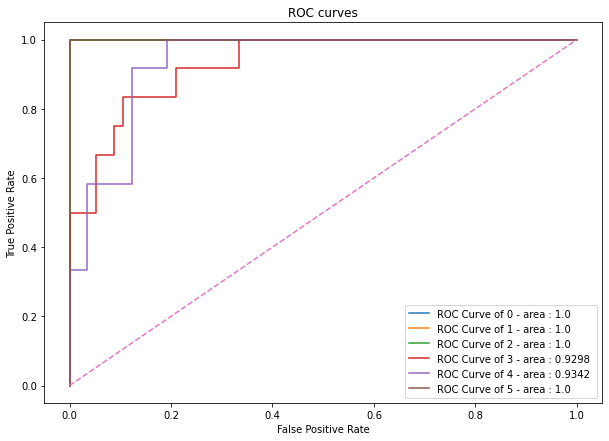

The accuracy score for train is  0.9710144927536232


In [39]:
split_data_log_regr_multi = splitontrain(best_l_log_regr_multi,1)
X_train_log_regr_multi = split_data_log_regr_multi.drop(split_data_log_regr_multi.columns[-1],axis=1)
y_train_log_regr_multi = split_data_log_regr_multi[split_data_log_regr_multi.columns[-1]]
le = preprocessing.LabelEncoder()
y_train_log_regr_multi = le.fit_transform(y_train_log_regr_multi)

best_model_log_regr_multi = LogisticRegression(penalty="l1", solver="saga",multi_class= 'multinomial', C=best_C_log_regr_multi)
best_model_log_regr_multi.fit(X_train_log_regr_multi, y_train_log_regr_multi)

y_pred_log_regr_multi = best_model_log_regr_multi.predict(X_train_log_regr_multi)
y_pred_log_regr_multi = le.fit_transform(y_pred_log_regr_multi)

clf_p = OneVsRestClassifier(LogisticRegression(C=best_C_log_regr_multi,penalty='l1', multi_class='multinomial',solver='saga'))
predict_prob = clf_p.fit(X_train_log_regr_multi, y_train_log_regr_multi).decision_function(X_train_log_regr_multi)

cnf_matrix_multi= confusion_matrix(y_train_log_regr_multi, y_pred_log_regr_multi)
print("Confusion Matrix")
print(cnf_matrix_multi)
    
fpr = dict()
tpr = dict()
roc_auc = dict()
fig, axes = plt.subplots(figsize=(10, 7))
for i, c in enumerate(best_model_log_regr_multi.classes_):
    fpr[i], tpr[i], threshold = roc_curve(y_train_log_regr_multi, predict_prob[:, i],pos_label=c)
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes.plot(fpr[i], tpr[i], label="ROC Curve of {} - area : {} ".format(c, round(roc_auc[i], 4)))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.set_title("ROC curves")
axes.legend()
plt.show()

train_accuracy_multi = metrics.accuracy_score(y_train_log_regr_multi, y_pred_log_regr_multi)
print("The accuracy score for train is ",train_accuracy_multi)

Confusion Matrix
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 1 0 2 0]
 [0 0 0 0 0 3]]


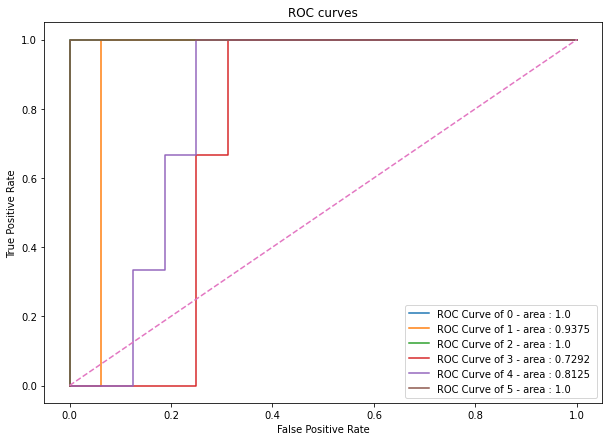

The accuracy score for test is  0.9473684210526315


In [41]:
split_data_log_regr_multi_test = splitontest(best_l_log_regr_multi,1)
X_test_log_regr_multi = split_data_log_regr_multi_test.drop(split_data_log_regr_multi_test.columns[-1],axis=1)
y_test_log_regr_multi = split_data_log_regr_multi_test[split_data_log_regr_multi_test.columns[-1]]
le = preprocessing.LabelEncoder()
y_test_log_regr_multi = le.fit_transform(y_test_log_regr_multi)

y_pred_log_regr_multi_test = best_model_log_regr_multi.predict(X_test_log_regr_multi)
y_pred_log_regr_multi_test = le.fit_transform(y_pred_log_regr_multi_test)

predict_prob = clf_p.fit(X_train_log_regr_multi, y_train_log_regr_multi).decision_function(X_test_log_regr_multi)

cnf_matrix_multi_test= confusion_matrix(y_test_log_regr_multi, y_pred_log_regr_multi_test)
print("Confusion Matrix")
print(cnf_matrix_multi_test)
    
fpr = dict()
tpr = dict()
roc_auc = dict()
fig, axes = plt.subplots(figsize=(10, 7))
for i, c in enumerate(best_model_log_regr_multi.classes_):
    fpr[i], tpr[i], threshold = roc_curve(y_test_log_regr_multi, predict_prob[:, i],pos_label=c)
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes.plot(fpr[i], tpr[i], label="ROC Curve of {} - area : {} ".format(c, round(roc_auc[i], 4)))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.set_title("ROC curves")
axes.legend()
plt.show()

test_accuracy_multi = metrics.accuracy_score(y_test_log_regr_multi, y_pred_log_regr_multi_test)
print("The accuracy score for test is ",test_accuracy_multi)

### ii. Repeat 2(c)i using a Na¨ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [42]:
#Gaussian
L1_log_regr_gau = {'l':[],'score':[]}

for i in range(1,21):
    L1_log_regr_gau['l'].append(i)
    split_train_by_l_g = splitontrain(i,1)
    X_g = split_train_by_l_g.drop(split_train_by_l_g.columns[-1],axis=1)
    y_g = split_train_by_l_g[split_train_by_l_g.columns[-1]]
    le_g = preprocessing.LabelEncoder()
    y_gn = le.fit_transform(y_g)
    gaussianClassifier = GaussianNB()
    gaussianClassifier.fit(X_g, y_gn)
    score_g = cross_val_score(gaussianClassifier, X_g, y_gn, cv=5)
    L1_log_regr_gau['score'].append(np.mean(score_g))
    
L1_log_regr_gau_df = pd.DataFrame(L1_log_regr_gau)
print(L1_log_regr_gau_df)

best_l_gau = L1_log_regr_gau['l'][L1_log_regr_gau['score'].index(np.amax(L1_log_regr_gau['score']))]
print("The best l is for Gaussian is ",best_l_gau)

     l     score
0    1  0.827473
1    2  0.840659
2    3  0.754945
3    4  0.796703
4    5  0.797802
5    6  0.797802
6    7  0.812088
7    8  0.783516
8    9  0.812088
9   10  0.740659
10  11  0.754945
11  12  0.783516
12  13  0.826374
13  14  0.781319
14  15  0.782418
15  16  0.812088
16  17  0.812088
17  18  0.770330
18  19  0.754945
19  20  0.769231
The best l is for Gaussian is  2


Confusion Matrix
[[ 8  0  1  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]


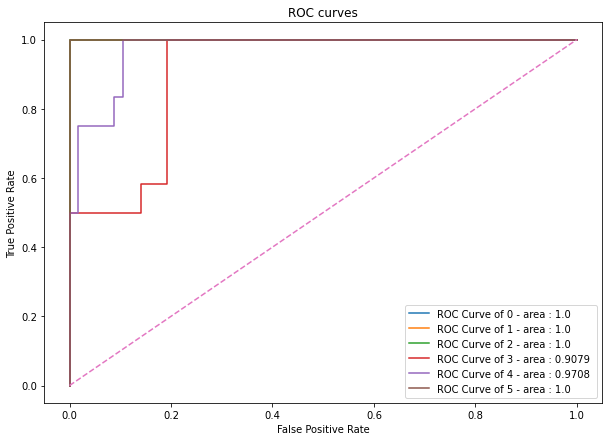

The accuracy score for Gaussian train is  0.9855072463768116


In [43]:
split_data_gau = splitontrain(best_l_gau,1)
X_train_gau = split_data_gau.drop(split_data_gau.columns[-1],axis=1)
y_train_gau = split_data_gau[split_data_gau.columns[-1]]

le = preprocessing.LabelEncoder()
y_train_gau = le.fit_transform(y_train_gau)

gaussian_model = GaussianNB()
gaussian_model.fit(X_train_gau, y_train_gau)

y_pred_gau = gaussian_model.predict(X_train_gau)
y_pred_gau = le.fit_transform(y_pred_gau)

clf_p = OneVsRestClassifier(GaussianNB())
predict_prob = clf_p.fit(X_train_gau, y_train_gau).predict_proba(X_train_gau)

cnf_matrix_gau= confusion_matrix(y_train_gau, y_pred_gau)
print("Confusion Matrix")
print(cnf_matrix_gau)
    
fpr = dict()
tpr = dict()
roc_auc = dict()
fig, axes = plt.subplots(figsize=(10, 7))
for i, c in enumerate(gaussian_model.classes_):
    fpr[i], tpr[i], threshold = roc_curve(y_train_gau, predict_prob[:, i],pos_label=c)
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes.plot(fpr[i], tpr[i], label="ROC Curve of {} - area : {} ".format(c, round(roc_auc[i], 4)))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.set_title("ROC curves")
axes.legend()
plt.show()

train_accuracy_gau = metrics.accuracy_score(y_train_gau, y_pred_gau)
print("The accuracy score for Gaussian train is ",train_accuracy_gau)

Confusion Matrix
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


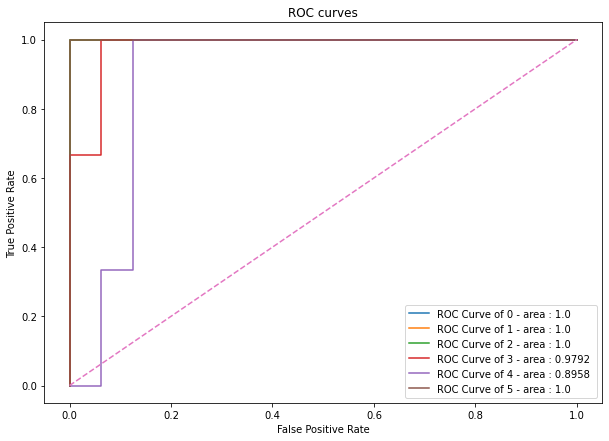

The accuracy score for Gaussian test is  0.9473684210526315


In [44]:
split_data_gau_test = splitontest(best_l_gau,1)
X_test_gau = split_data_gau_test.drop(split_data_gau_test.columns[-1],axis=1)
y_test_gau = split_data_gau_test[split_data_gau_test.columns[-1]]
le = preprocessing.LabelEncoder()
y_test_gau = le.fit_transform(y_test_gau)

y_pred_test_gau = gaussian_model.predict(X_test_gau)
y_pred_test_gau = le.fit_transform(y_pred_test_gau)

predict_prob = clf_p.fit(X_train_gau, y_train_gau).predict_proba(X_test_gau)

cnf_matrix_gau_test= confusion_matrix(y_test_gau, y_pred_test_gau)
print("Confusion Matrix")
print(cnf_matrix_gau_test)
    
fpr = dict()
tpr = dict()
roc_auc = dict()
fig, axes = plt.subplots(figsize=(10, 7))
for i, c in enumerate(gaussian_model.classes_):
    fpr[i], tpr[i], threshold = roc_curve(y_test_gau, predict_prob[:, i],pos_label=c)
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes.plot(fpr[i], tpr[i], label="ROC Curve of {} - area : {} ".format(c, round(roc_auc[i], 4)))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.set_title("ROC curves")
axes.legend()
plt.show()

test_accuracy_gau = metrics.accuracy_score(y_test_gau, y_pred_test_gau)
print("The accuracy score for Gaussian test is ",test_accuracy_gau)

In [45]:
#Multinomial
L1_log_regr_multn = {'l':[],'score':[]}

for i in range(1,21):
    L1_log_regr_multn['l'].append(i)
    split_train_by_l_nmul = splitontrain(i,1)
    X_nmul = split_train_by_l_nmul.drop(split_train_by_l_nmul.columns[-1],axis=1)
    y_nmul = split_train_by_l_nmul[split_train_by_l_nmul.columns[-1]]
    le = preprocessing.LabelEncoder()
    y_multn = le.fit_transform(y_nmul)
    multinomial = MultinomialNB()
    multinomial.fit(X_nmul, y_multn)
    L1_log_regr_multn['score'].append(multinomial.score(X_nmul, y_multn))
    
L1_log_regr_multn_df = pd.DataFrame(L1_log_regr_multn)
print(L1_log_regr_multn_df)

best_l_multn = L1_log_regr_multn['l'][L1_log_regr_multn['score'].index(np.amax(L1_log_regr_multn['score']))]
print("The best l is: ",best_l_multn)

     l     score
0    1  0.942029
1    2  0.942029
2    3  0.942029
3    4  0.971014
4    5  0.971014
5    6  0.971014
6    7  0.971014
7    8  0.971014
8    9  0.971014
9   10  0.971014
10  11  0.956522
11  12  0.971014
12  13  0.956522
13  14  0.971014
14  15  0.956522
15  16  0.956522
16  17  0.956522
17  18  0.956522
18  19  0.956522
19  20  0.956522
The best l is:  4


Confusion Matrix
[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 1  0  0 11  0  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  0 12]]


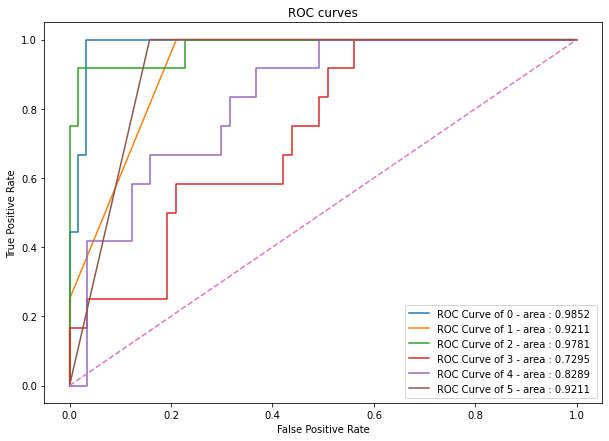

The accuracy score for Multinomial train is  0.9710144927536232


In [46]:
split_data_multn = splitontrain(best_l_multn,1)
X_train_multn = split_data_multn.drop(split_data_multn.columns[-1],axis=1)
y_train_multn = split_data_multn[split_data_multn.columns[-1]]
le = preprocessing.LabelEncoder()
y_train_multn = le.fit_transform(y_train_multn)

multinomial_model = MultinomialNB()
multinomial_model.fit(X_train_multn, y_train_multn)
y_pred_multn = multinomial_model.predict(X_train_multn)
y_pred_multn = le.fit_transform(y_pred_multn)


clf_p = OneVsRestClassifier(MultinomialNB())
predict_prob = clf_p.fit(X_train_multn, y_train_multn).predict_proba(X_train_multn)

cnf_matrix_multn= confusion_matrix(y_train_multn, y_pred_multn)
print("Confusion Matrix")
print(cnf_matrix_multn)
    
fpr = dict()
tpr = dict()
roc_auc = dict()
fig, axes = plt.subplots(figsize=(10, 7))
for i, c in enumerate(multinomial_model.classes_):
    fpr[i], tpr[i], threshold = roc_curve(y_train_multn, predict_prob[:, i],pos_label=c)
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes.plot(fpr[i], tpr[i], label="ROC Curve of {} - area : {} ".format(c, round(roc_auc[i], 4)))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.set_title("ROC curves")
axes.legend()
plt.show()

train_accuracy_multn = metrics.accuracy_score(y_train_multn, y_pred_multn)
print("The accuracy score for Multinomial train is ",train_accuracy_multn)

Confusion Matrix
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


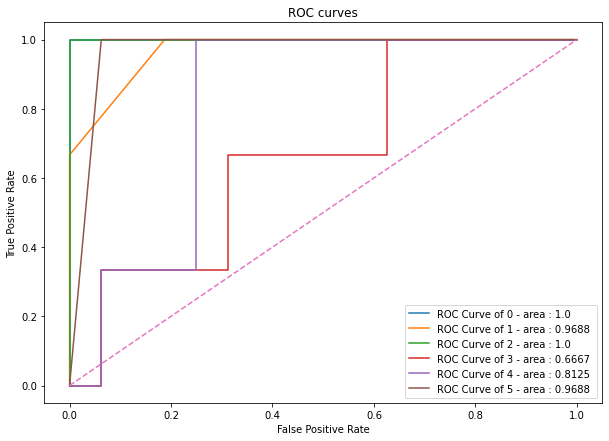

The accuracy score for Multinomial test is  0.9473684210526315


In [47]:
split_data_multn_test = splitontest(best_l_multn,1)
X_test_multn = split_data_multn_test.drop(split_data_multn_test.columns[-1],axis=1)
y_test_multn = split_data_multn_test[split_data_multn_test.columns[-1]]

le = preprocessing.LabelEncoder()
y_test_multn = le.fit_transform(y_test_multn)

y_pred_test_multn = multinomial_model.predict(X_test_multn)
y_pred_test_multn = le.fit_transform(y_pred_test_multn)

predict_prob = clf_p.fit(X_train_multn, y_train_multn).predict_proba(X_test_multn)

cnf_matrix_test_multn= confusion_matrix(y_test_multn, y_pred_test_multn)
print("Confusion Matrix")
print(cnf_matrix_test_multn)
    
fpr = dict()
tpr = dict()
roc_auc = dict()
fig, axes = plt.subplots(figsize=(10, 7))
for i, c in enumerate(multinomial_model.classes_):
    fpr[i], tpr[i], threshold = roc_curve(y_test_multn, predict_prob[:, i],pos_label=c)
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes.plot(fpr[i], tpr[i], label="ROC Curve of {} - area : {} ".format(c, round(roc_auc[i], 4)))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.set_title("ROC curves")
axes.legend()
plt.show()

test_accuracy_multn = metrics.accuracy_score(y_test_multn, y_pred_test_multn)
print("The accuracy score for Multinomial test is ",test_accuracy_multn)

### iii. Which method is better for multi-class classification in this problem?

Multinomial Naive Bayes is better for features that depend on the frequency and Gaussian is preferred when the features are continuous.